# 3-D Exodus example

Anthony Gruber 3-31-2023

In [3]:
# Imports for exodus
import sys
sys.path.append('/Users/adgrube/Desktop/Code/seacas/lib')  ### replace with your Seacas installation
import exodus

# Standard imports
import numpy as np
# from scipy.linalg import svd
from scipy.sparse import eye, csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import mmread, loadmat
import matplotlib.pyplot as plt

# Import for utils
sys.path.append("..")

import OpInf_utils as ou
import ROM_utils as ru

# To suppress annoying umfpack "almost singular" warnings
import warnings
warnings.filterwarnings('ignore', '.*singular matrix!.*')

# Creating exodus file
fromFileName = 'beam_velIC_100.e'
toFileName   = 'beam_vecIC_100_written.e'

massName  = 'mass.mm'
stiffName = 'stiff.mm'

ROMvariables = ['exactSol_x', 'exactSol_y', 'exactSol_z',
                '1-disp_G-OpRom_x', '1-disp_G-OpRom_y', '1-disp_G-OpRom_z',
                '1-disp_NC-H-OpRom_x', '1-disp_NC-H-OpRom_y', '1-disp_NC-H-OpRom_z',
                '1-disp_C-H-OpRom_x', '1-disp_C-H-OpRom_y', '1-disp_C-H-OpRom_z',
                '1-disp_G-IntRom_x', '1-disp_G-IntRom_y', '1-disp_G-IntRom_z',
                '1-disp_H-IntRom_x', '1-disp_H-IntRom_y', '1-disp_H-IntRom_z',
                '2-disp_G-OpRom_x', '2-disp_G-OpRom_y', '2-disp_G-OpRom_z',
                '2-disp_NC-H-OpRom_x', '2-disp_NC-H-OpRom_y', '2-disp_NC-H-OpRom_z',
                '2-disp_C-H-OpRom_x', '2-disp_C-H-OpRom_y', '2-disp_C-H-OpRom_z',
                '2-disp_G-IntRom_x', '2-disp_G-IntRom_y', '2-disp_G-IntRom_z',
                '2-disp_H-IntRom_x', '2-disp_H-IntRom_y', '2-disp_H-IntRom_z',
                '3-disp_G-OpRom_x', '3-disp_G-OpRom_y', '3-disp_G-OpRom_z',
                '3-disp_NC-H-OpRom_x', '3-disp_NC-H-OpRom_y', '3-disp_NC-H-OpRom_z',
                '3-disp_C-H-OpRom_x', '3-disp_C-H-OpRom_y', '3-disp_C-H-OpRom_z',
                '3-disp_G-IntRom_x', '3-disp_G-IntRom_y', '3-disp_G-IntRom_z',
                '3-disp_H-IntRom_x', '3-disp_H-IntRom_y', '3-disp_H-IntRom_z']

# Use this the first time the file is created
# exo_copy = exodus.copyTransfer(fromFileName, toFileName,
#                                array_type='numpy',
#                                additionalNodalVariables=ROMvariables)

# # Use this after file is created
exo_copy = exodus.exodus(f'{toFileName}', array_type='numpy')

Opening exodus file: beam_vecIC_100_written.e


### Function which grabs snapshots from Irina's data and assembles FOM quantities

In [4]:
# Function which grabs everything from the exodus file
# The snapshots are kind of weird -- energy drops after first iteration

def assemble_FOM(exo_file):
    # Import mass and stiffness matrices
    N     = exo_file.num_nodes()
    Nt    = exo_file.num_times()
    mass  = mmread(massName)
    stiff = mmread(stiffName)

    # stiff = 0.5 * (stiff+stiff.T)
    # mass  = 0.5 * (mass+mass.T)
    M = mass.todense()
    K = stiff.todense()


    # Build L matrix
    zz    = np.zeros((3*N, 3*N))
    ii    = np.eye(3*N)
    J     = np.block([[zz, ii], [-ii, zz]])

    # BCset = [0,0,0,0,0,0]
    # BCdofs = []
    # for i in range(6):
    #     BCset[i] = exo_file.get_node_set_nodes(i+1)
    # for i in range(2):
    #     xdofs = (BCset[i]-1)*3 + 0
    #     BCdofs.append(xdofs)
    # for i in range(2,4):
    #     ydofs = (BCset[i]-1)*3 + 1
    #     BCdofs.append(ydofs)
    # for i in range(4,6):
    #     zdofs = (BCset[i]-1)*3 + 2
    #     BCdofs.append(zdofs)

    # BCdofs = np.concatenate(BCdofs, axis=0)

    # ii[BCdofs] = np.zeros(3*N)
    # J     = np.block([[zz, ii], [-ii, zz]])

    # for grad H
    massInv = spsolve(mass.tocsc(), eye(3*N).tocsc())
    A       = np.block([[stiff.todense(), zz], [zz, massInv.todense()]])

    # Solution arrays ordered by node_id
    sol_x   = np.zeros((N, Nt))
    sol_y   = np.zeros((N, Nt))
    sol_z   = np.zeros((N, Nt))

    # for position
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('disp_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('disp_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('disp_z', t+1)

    # Full position array (interleaved like M, K matrices)
    q_arr       = np.zeros((3*N, Nt))
    q_arr[0::3] = sol_x
    q_arr[1::3] = sol_y
    q_arr[2::3] = sol_z

    # for derivative of position
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('solution_dot_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('solution_dot_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('solution_dot_z', t+1)

    # Full qDot array
    qDot_arr       = np.zeros((3*N, Nt))
    qDot_arr[0::3] = sol_x
    qDot_arr[1::3] = sol_y
    qDot_arr[2::3] = sol_z

    # Full momentum array (interleaved)
    p_arr = mass @ qDot_arr

    # for derivative of momentum
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('solution_dotdot_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('solution_dotdot_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('solution_dotdot_z', t+1)

    # Full pDot array
    pDot_arr       = np.zeros((3*N, Nt))
    pDot_arr[0::3] = sol_x
    pDot_arr[1::3] = sol_y
    pDot_arr[2::3] = sol_z
    pDot_arr       = mass @ pDot_arr

    # Build state, state derivative, and gradH
    x_arr     = np.concatenate((q_arr, p_arr), axis=0)
    xDot_arr  = np.concatenate((qDot_arr, pDot_arr), axis=0)
    gradH_arr = csc_matrix(A) @ x_arr

    return (x_arr, xDot_arr, gradH_arr), J, A


# Compute Hamiltonian
def Hamil(data, A):
    result = np.zeros(data.shape[1])
    for i in range(len(result)):
        result[i] = data[:,i].T @ A @ data[:,i]
    return 0.5 * result

## Computing the FOM solution in Hamiltonian form and building POD basis

In [5]:
# Get data from exodus file (201 snaps)
data, J, A     = assemble_FOM(exo_copy)
Asp            = csc_matrix(A)
Jsp            = csc_matrix(J)

# Doing the integration (takes about 2:40)
tTrain = np.linspace(0, 0.02, 201)
Xt, Xdt, gHt = ru.integrate_Linear_HFOM(tTrain, data[0][:,0], Jsp, Asp)

#Saving the data
# dicto = {'x': Xt, 'xDot': Xdt, 'gradH': gHt}
# from scipy.io import savemat
# savemat('exo_snap201.mat', dicto)

# # Ignore exodus file and get data from Hamiltonian system
# mat            = loadmat('clamped/exo_snaps.mat')
# xData          = mat['x']
# xDotData       = mat['xDot']
# gradHData      = mat['gradH']

xData, xDotData, gradHData = Xt, Xdt, gHt
# xData, xDotData, gradHData = data


## Computing POD bases and snapshot plots

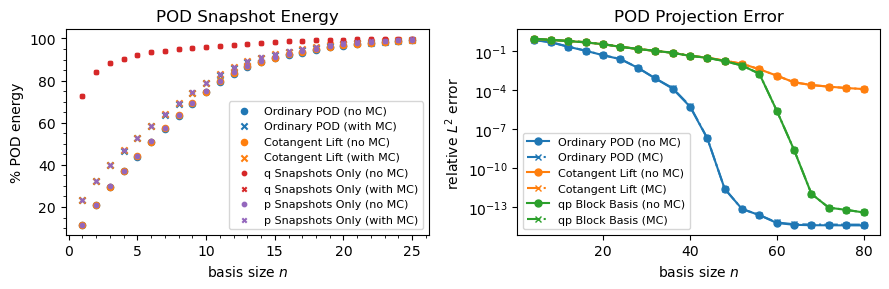

In [6]:
X = xData
Xmc = X - X[:,0].reshape(-1,1)
Nt = X.shape[1]
Nover2 = X.shape[0]//2

## Ordinary POD algo
UU, SS     = np.linalg.svd(X[:,:Nt])[:2]
UUmc, SSmc = np.linalg.svd(Xmc[:,:Nt])[:2]

### Cotangent lift algo:  U here is half the length of other one
Xlong        = np.concatenate((X[:Nover2,:Nt], X[Nover2:,:Nt]), axis=1)
Xmclong      = np.concatenate((Xmc[:Nover2,:Nt], Xmc[Nover2:,:Nt]), axis=1)
UU2, SS2     = np.linalg.svd(Xlong)[:2]
UU2mc, SS2mc = np.linalg.svd(Xmclong)[:2]

### Block q,p algo
UUq, SSq = np.linalg.svd(X[:Nover2,:Nt])[:2]
UUqmc, SSqmc = np.linalg.svd(Xmc[:Nover2,:Nt])[:2]
UUp, SSp = np.linalg.svd(X[Nover2:,:Nt])[:2]
UUpmc, SSpmc = np.linalg.svd(Xmc[Nover2:,:Nt])[:2]


nEigs = 25
idx = [i+1 for i in range(nEigs)]
X1 = X[:,:Nt]
ic = X[:,0].reshape(-1,1)

name = "tab10"
cmap = plt.get_cmap(name)

nList = [4*(i+1) for i in range(20)]
errU  = np.zeros(len(nList))
errUmc = np.zeros(len(nList))
errU2  = np.zeros(len(nList))
errU2mc = np.zeros(len(nList))
errUqp  = np.zeros(len(nList))
errUqpmc = np.zeros(len(nList))
for i,n in enumerate(nList):
    Umc   = UUmc[:,:n]
    U     = UU[:,:n]
    Ub    = UU2mc[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2mc = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Ub    = UU2[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2    = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Uq    = UUqmc[:,:n//2]
    Up    = UUpmc[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqpmc = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))
    Uq    = UUq[:,:n//2]
    Up    = UUp[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqp   = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))

    reconUmc   = ic.reshape(-1,1) + Umc @ Umc.T @ (X1 - ic.reshape(-1,1))
    reconU     = U @ U.T @ X1
    reconU2mc  = ic.reshape(-1,1) + U2mc @ U2mc.T @ (X1 - ic.reshape(-1,1))
    reconU2    = U2 @ U2.T @ X1
    reconUqpmc = ic.reshape(-1,1) + Uqpmc @ Uqpmc.T @ (X1 - ic.reshape(-1,1))
    reconUqp   = Uqp @ Uqp.T @ X1

    errUmc[i]   = ru.relError(X1, reconUmc)
    errU[i]     = ru.relError(X1, reconU)
    errU2mc[i]  = ru.relError(X1, reconU2mc)
    errU2[i]    = ru.relError(X1, reconU2)
    errUqpmc[i] = ru.relError(X1, reconUqpmc)
    errUqp[i]   = ru.relError(X1, reconUqp)

from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, np.cumsum(SS[:nEigs] / np.sum(SS))*100, s=20., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SSmc[:nEigs] / np.sum(SSmc))*100, s=20., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SS2[:nEigs] / np.sum(SS2))*100, s=20., label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SS2mc[:nEigs] / np.sum(SS2mc))*100, s=20., label='Cotangent Lift (with MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SSq[:nEigs] / np.sum(SSq))*100, s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSqmc[:nEigs] / np.sum(SSqmc))*100, s=10., label='q Snapshots Only (with MC)', marker='x', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSp[:nEigs] / np.sum(SSp))*100, s=10., label='p Snapshots Only (no MC)', color=cmap.colors[4])
ax[0].scatter(idx, np.cumsum(SSpmc[:nEigs] / np.sum(SSpmc))*100, s=10., label='p Snapshots Only (with MC)', marker='x', color=cmap.colors[4])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, errU, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errUmc, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errU2, label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errU2mc, label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errUqp, label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, errUqpmc, label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[2])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
# plt.savefig('solidmechPODenergy', transparent=True)
plt.show()

## Computing the ROMs

Here I compute all of the relevant ROM solutions and plot the errors (predictive case)

/Users/adgrube/Desktop/Code/HamiltonianOpInf/CantileverPlate/../ROM_utils.py:149: RuntimeWarning: overflow encountered in matmul
  rhs         = dt * (x0part + LAHat @ xHat[:,i])
/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_37476/3767284368.py:102: RuntimeWarning: overflow encountered in matmul
  result[i] = data[:,i].T @ A @ data[:,i]


0 the relative L2 errors for intrusive GROM are [5.66657474e+02 3.02357878e+17 2.29649182e+10 1.69457577e+00
 1.00000000e+00 1.40197914e+09 2.66341912e+10 6.56114163e+16
 1.42862352e+24 2.70983263e-02 3.78668240e-05 1.00074852e-08
            inf 6.19949287e+84            inf 3.16967962e+28
 1.71861614e+23 4.58860656e+50 5.55808951e+23 8.31520127e+88
 1.25055287e-06 1.45432624e+17 8.71267907e+02 9.84324203e+42
 6.55617633e+04]
0 the relative L2 errors for intrusive HROM are [1.49998341 1.50087791 1.50155773 1.50269914 1.         1.27921522
 1.51405566 1.53840582 1.55729549 1.4541955  1.53420403 1.42528704
 1.39122023 1.42863993 1.28125778 1.31246018 1.23294171 1.41658603
 1.42819329 1.43582381 1.451415   1.4891519  1.47293694 1.48515748
 1.53185845]
0 the relative L2 errors for generic OpInf are [8.57519453e+019 4.01651559e+014 1.50893342e+022 5.21194133e+003
             inf 5.13071326e+002 2.74834779e+005 1.28077172e+010
 6.54528898e+001 1.11982505e-001 1.29137419e-004 7.92710665e-00

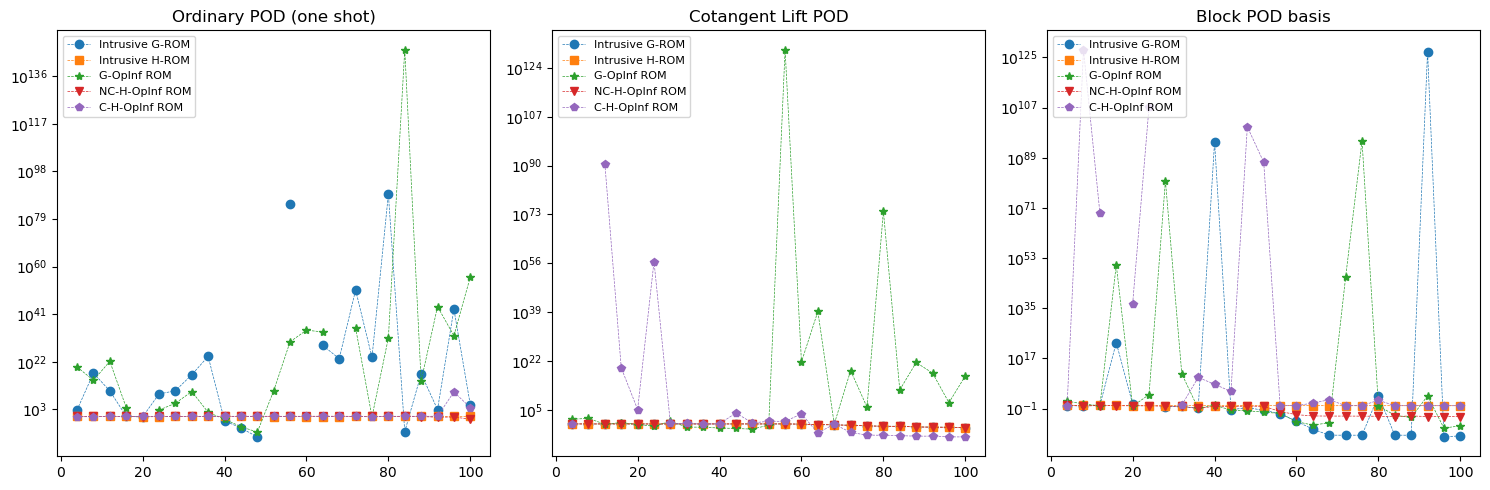

In [7]:
### Exact solution
Ttest     = 1e-1
NtTest    = 201
tTest     = np.linspace(0, Ttest, NtTest)
ic        = data[0][:,0]
# Xac       = X
Xac = ru.integrate_Linear_HFOM(tTest, ic, Jsp, Asp)[0]
exactE = Hamil(Xac, Asp)

Xd, gH, L, A = xDotData, gradHData, Jsp, Asp

### Parameters
# oneShotList = [True, True, True]
oneShotList = [True, False, False]
UmatList    = [UU, [UU2,UU2], [UUq,UUp]]
SigmaList   = [SS, None, None]
MCtog       = [True, True, True]
if any(MCtog):
    UmatListMC = [UUmc, [UU2mc, UU2mc], [UUqmc, UUpmc]]

nList = [4*(i+1) for i in range(25)]
eIntG  = np.zeros((3, len(nList)))
eIntH  = np.zeros((3, len(nList)))
eOpH   = np.zeros((3, len(nList)))
eOp    = np.zeros((3, len(nList)))
eOpA   = np.zeros((3, len(nList)))

HamileIntG = np.zeros((3, len(nList), NtTest))
HamileIntH = np.zeros((3, len(nList), NtTest))
HamileOpH  = np.zeros((3, len(nList), NtTest))
HamileOp   = np.zeros((3, len(nList), NtTest))
HamileOpA  = np.zeros((3, len(nList), NtTest))

XrecIntG = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecIntH = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpH  = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpA  = np.zeros((3, len(nList), 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5))

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block POD basis']

alpha=1

for i in range(len(UmatList)):

    OpInfLists  = ou.build_OpInf_stuff(UmatList[i], X[:,:Nt], Xd[:,:Nt], 
                                        gH[:,:Nt], L, nList[-1])
    OpLists     = ru.build_Linear_ROM_Ops(UmatList[i], L, A, ic, MC=False)
    OpListOL    = list(OpLists[0])
    
    if MCtog[i]:
        OpInfListMC = ou.build_OpInf_stuff(UmatListMC[i], X[:,:Nt], Xd[:,:Nt], 
                                           gH[:,:Nt], L, nList[-1], MC=True)
        OpListsMC   = ru.build_Linear_ROM_Ops(UmatListMC[i], L, A, ic, MC=True)
        OpListMCOL  = list(OpListsMC[0])

    if oneShotList[i]:
        # Compute once and for all
        if MCtog[i]:
            LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=1.0e-12)
        else:
            LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=1.0e-12)
        
        AhatOpFull        = ou.C_H_OpInf(OpInfLists[1], nList[-1], SigmaList[i], eps=1.0e-10)

    DhatOpFull            = ou.G_OpInf(OpInfLists[-1], nList[-1], SigmaList[i], eps=1.0e-10)

    for j,n in enumerate(nList):

        if not oneShotList[i]:
            # Compute for each n
            DhatOp  = ou.G_OpInf(OpInfLists[-1], n, SigmaList[i], eps=1.0e-10)
            if MCtog[i]:
                LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=1.0e-12)
            else:
                LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=1.0e-12)
            
            AhatOp        = ou.C_H_OpInf(OpInfLists[1], n, SigmaList[i], eps=1.0e-10, BorisZhu=False)
        else:
            if isinstance(UmatList[i], list):
                Ablock1 = AhatOpFull[:n//2, :n//2]
                idx = nList[-1]//2
                Ablock2 = AhatOpFull[idx:idx+n//2,idx:idx+n//2]
                AhatOp  = csc_matrix(np.block([[Ablock1, np.zeros((n//2,n//2))], 
                                              [np.zeros((n//2,n//2)), Ablock2]]))

                Dblock1 = DhatOpFull[:n//2, :n//2]
                idx = nList[-1]//2
                Dblock2 = DhatOpFull[idx:idx+n//2,idx:idx+n//2]
                DhatOp  = csc_matrix(np.block([[Dblock1, np.zeros((n//2,n//2))], 
                                              [np.zeros((n//2,n//2)), Dblock2]]))
                                              
            else:
                DhatOp  = DhatOpFull[:n,:n]
                AhatOp  = AhatOpFull[:n,:n]

            if MCtog[i]:
                LhatHOpMC = LhatHOpFullMC[:n,:n]
            else:
                LhatHOp   = LhatHOpFull[:n,:n]
        
        if MCtog[i]:
            OpListMCOL[0] = LhatHOpMC
            try:
                XrecIntG[i,j] = ru.integrate_Linear_ROM(tTest, OpListsMC[1], ic, UmatListMC[i], n, MC=True)
                XrecIntH[i,j] = ru.integrate_Linear_ROM(tTest, OpListsMC[0], ic, UmatListMC[i],
                                                        n, MC=True, Hamiltonian=True)
                XrecOpH[i,j]  = ru.integrate_Linear_ROM(tTest, OpListMCOL, ic, UmatListMC[i],
                                                        n, MC=True, Hamiltonian=True)
            except ValueError:
                pass
        else:
            OpListOL[0] = LhatHOp
            try:
                XrecIntG[i,j] = ru.integrate_Linear_ROM(tTest, OpLists[1], ic, UmatList[i], n, MC=False)
                XrecIntH[i,j] = ru.integrate_Linear_ROM(tTest, OpLists[0], ic, UmatList[i],
                                                        n, MC=False, Hamiltonian=True)
                XrecOpH[i,j]  = ru.integrate_Linear_ROM(tTest, OpListOL, ic, UmatList[i],
                                                        n, MC=False, Hamiltonian=True)
            except ValueError:
                pass

        try:
            XrecOp[i,j]   = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UmatList[i])
            XrecOpA[i,j]  = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, UmatList[i], L)
        except ValueError:
            pass

        eIntG[i,j] = ru.relError(Xac, XrecIntG[i,j])
        eIntH[i,j] = ru.relError(Xac, XrecIntH[i,j])
        eOp[i,j]   = ru.relError(Xac, XrecOp[i,j])
        eOpH[i,j]  = ru.relError(Xac, XrecOpH[i,j])
        eOpA[i,j]  = ru.relError(Xac, XrecOpA[i,j])

        # HamileIntG[i,j] = np.abs(Hamil(XrecIntG[i,j], Asp) - exactE)
        # HamileIntH[i,j] = np.abs(Hamil(XrecIntH[i,j], Asp) - exactE)
        # HamileOp[i,j]   = np.abs(Hamil(XrecOp[i,j], Asp) - exactE)
        # HamileOpH[i,j]  = np.abs(Hamil(XrecOpH[i,j], Asp) - exactE)
        # HamileOpA[i,j]  = np.abs(Hamil(XrecOpA[i,j], Asp) - exactE)

        HamileIntG[i,j] = Hamil(XrecIntG[i,j], Asp)
        HamileIntH[i,j] = Hamil(XrecIntH[i,j], Asp)
        HamileOp[i,j]   = Hamil(XrecOp[i,j], Asp)
        HamileOpH[i,j]  = Hamil(XrecOpH[i,j], Asp)
        HamileOpA[i,j]  = Hamil(XrecOpA[i,j], Asp)

    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    # ax.flatten()[i].set_ylim([10**-5, 10.])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)

plt.tight_layout()
# plt.savefig(f'PlatePlotPred', transparent=True)
plt.show()

### Zoomed-in Plot for paper

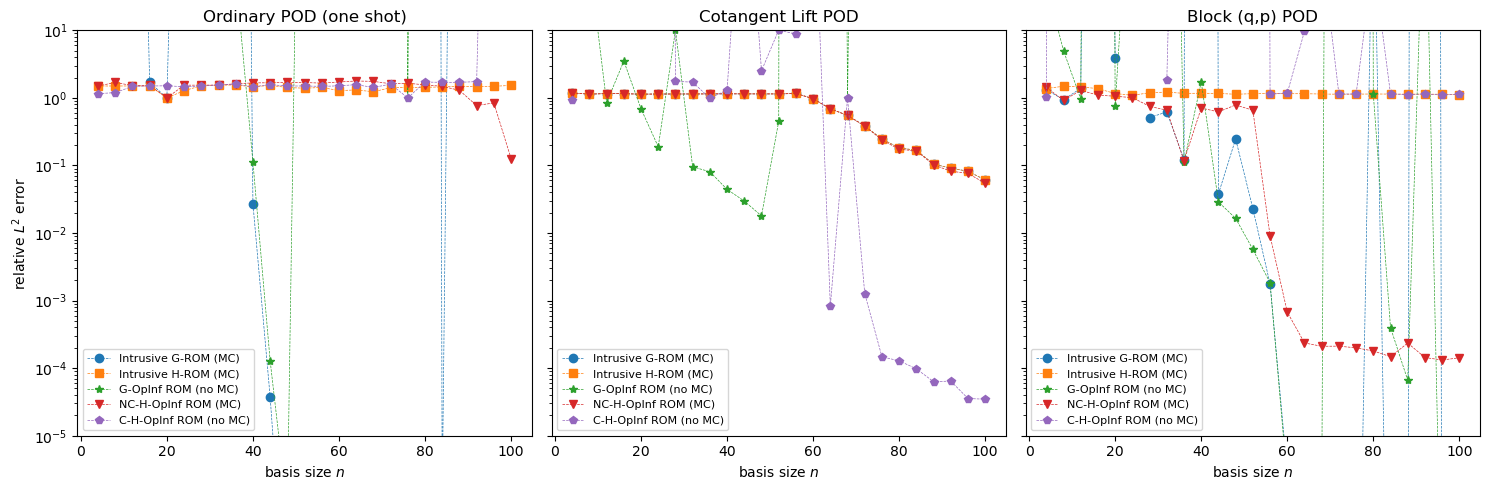

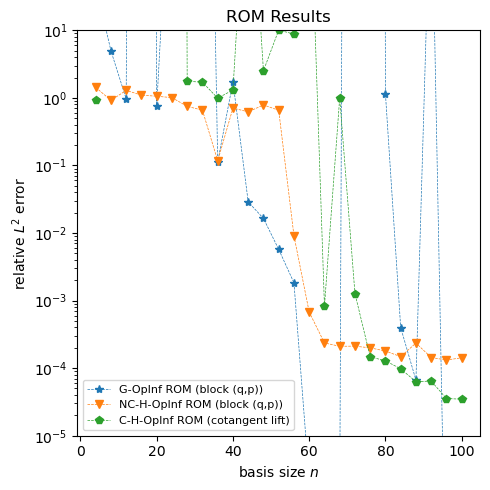

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
                'Block (q,p) POD']

float_formatter = "{:.2e}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

alpha=1

for i in range(len(UmatList)):

    # # Print error magnitudes
    # print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    # print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    # print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    # print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    # print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_xlabel('basis size $n$')
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=3)
    ax.flatten()[i].set_ylim([10**-5, 10.])

ax.flatten()[0].set_ylabel(r'relative $L^2$ error')
# ax.flatten()[0].set_ylim([10**-4, 10.])
# ax.flatten()[1].set_ylim([10**-4, 10.])
# ax.flatten()[2].set_ylim([10**-4, 10.])
plt.tight_layout()
# plt.savefig(f'PlatePlotPredZoom', transparent=True)
plt.show()


# fig, ax = plt.subplots(1, 1, figsize=(5,5))

# ax.semilogy(nList, eIntG[2], label='Intrusive G-ROM (block (q,p))', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eIntH[1], label='Intrusive H-ROM (cotangent lift)', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eOp[2],  label='G-OpInf ROM (block (q,p))', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eOpH[2], label='NC-H-OpInf ROM (block (q,p))', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eOpA[1], label='C-H-OpInf ROM (cotangent lift)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.set_xlabel('basis size $n$')
# ax.set_title('ROM Results')
# ax.legend(prop={'size':8}, loc=3)
# ax.set_ylim([10**-5, 10.])

# ax.set_ylabel(r'relative $L^2$ error')
# # ax.flatten()[0].set_ylim([10**-4, 10.])
# # ax.flatten()[1].set_ylim([10**-4, 10.])
# # ax.flatten()[2].set_ylim([10**-4, 10.])
# plt.tight_layout()
# plt.savefig(f'best_cases_for_Irina', transparent=True)
# plt.show()


### Saving solution data to Exodus file

In [7]:
N = 1764

iList = [0, 1, 2]
jList = [11, 24, 23]

disp_xTest  = Xac[::3][:N]
disp_yTest  = Xac[1::3][:N]
disp_zTest  = Xac[2::3][:N]

for k in range(201):
    exo_copy.put_node_variable_values("exactSol_x", k+1, disp_xTest[:,k])
    exo_copy.put_node_variable_values("exactSol_y", k+1, disp_yTest[:,k])
    exo_copy.put_node_variable_values("exactSol_z", k+1, disp_zTest[:,k])

for l in range(3):
    i = iList[l]
    j = jList[l]

    print(f'num modes is {4*(jList[l]+1)}')
    print(f'errors are' + '\n' + f'{eIntG[i,j]}' + '\n' + f'{eIntH[i,j]}' + '\n' 
          + f'{eOp[i,j]}' + '\n' + f'{eOpH[i,j]}' + '\n' + f'{eOpA[i,j]}' + '\n')

    disp_xRecIntG = XrecIntG[i,j][::3][:N]
    disp_yRecIntG = XrecIntG[i,j][1::3][:N]
    disp_zRecIntG = XrecIntG[i,j][2::3][:N]

    disp_xRecIntH = XrecIntH[i,j][::3][:N]
    disp_yRecIntH = XrecIntH[i,j][1::3][:N]
    disp_zRecIntH = XrecIntH[i,j][2::3][:N]

    disp_xRecOpH = XrecOpH[i,j][::3][:N]
    disp_yRecOpH = XrecOpH[i,j][1::3][:N]
    disp_zRecOpH = XrecOpH[i,j][2::3][:N]

    disp_xRecOpA = XrecOpA[i,j][::3][:N]
    disp_yRecOpA = XrecOpA[i,j][1::3][:N]
    disp_zRecOpA = XrecOpA[i,j][2::3][:N]

    disp_xRecOp  = XrecOp[i,j][::3][:N]
    disp_yRecOp  = XrecOp[i,j][1::3][:N]
    disp_zRecOp  = XrecOp[i,j][2::3][:N]

    for k in range(201):
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-IntRom_x", k+1, disp_xRecIntG[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-IntRom_y", k+1, disp_yRecIntG[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-IntRom_z", k+1, disp_zRecIntG[:,k])

        exo_copy.put_node_variable_values(f"{l+1}-disp_H-IntRom_x", k+1, disp_xRecIntH[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_H-IntRom_y", k+1, disp_yRecIntH[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_H-IntRom_z", k+1, disp_zRecIntH[:,k])

        exo_copy.put_node_variable_values(f"{l+1}-disp_NC-H-OpRom_x", k+1, disp_xRecOpH[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_NC-H-OpRom_y", k+1, disp_yRecOpH[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_NC-H-OpRom_z", k+1, disp_zRecOpH[:,k])

        exo_copy.put_node_variable_values(f"{l+1}-disp_C-H-OpRom_x", k+1, disp_xRecOpA[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_C-H-OpRom_y", k+1, disp_yRecOpA[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_C-H-OpRom_z", k+1, disp_zRecOpA[:,k])

        exo_copy.put_node_variable_values(f"{l+1}-disp_G-OpRom_x", k+1, disp_xRecOp[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-OpRom_y", k+1, disp_yRecOp[:,k])
        exo_copy.put_node_variable_values(f"{l+1}-disp_G-OpRom_z", k+1, disp_zRecOp[:,k])

num modes is 48
errors are
1.0007485226355967e-08
1.425287043336767
7.927106647024469e-07
1.6961547086113744
1.4979072115917573

num modes is 100
errors are
0.06098250319339035
0.06098250319339552
5.870085701991545e+16
0.05443534524474592
3.4711419531845164e-05

num modes is 96
errors are
7.0937318799832985e-12
1.1329021094826957
9.571363643950397e-09
0.0001319989175533905
1.1045891039948055



### Plots of Hamiltonian conservation

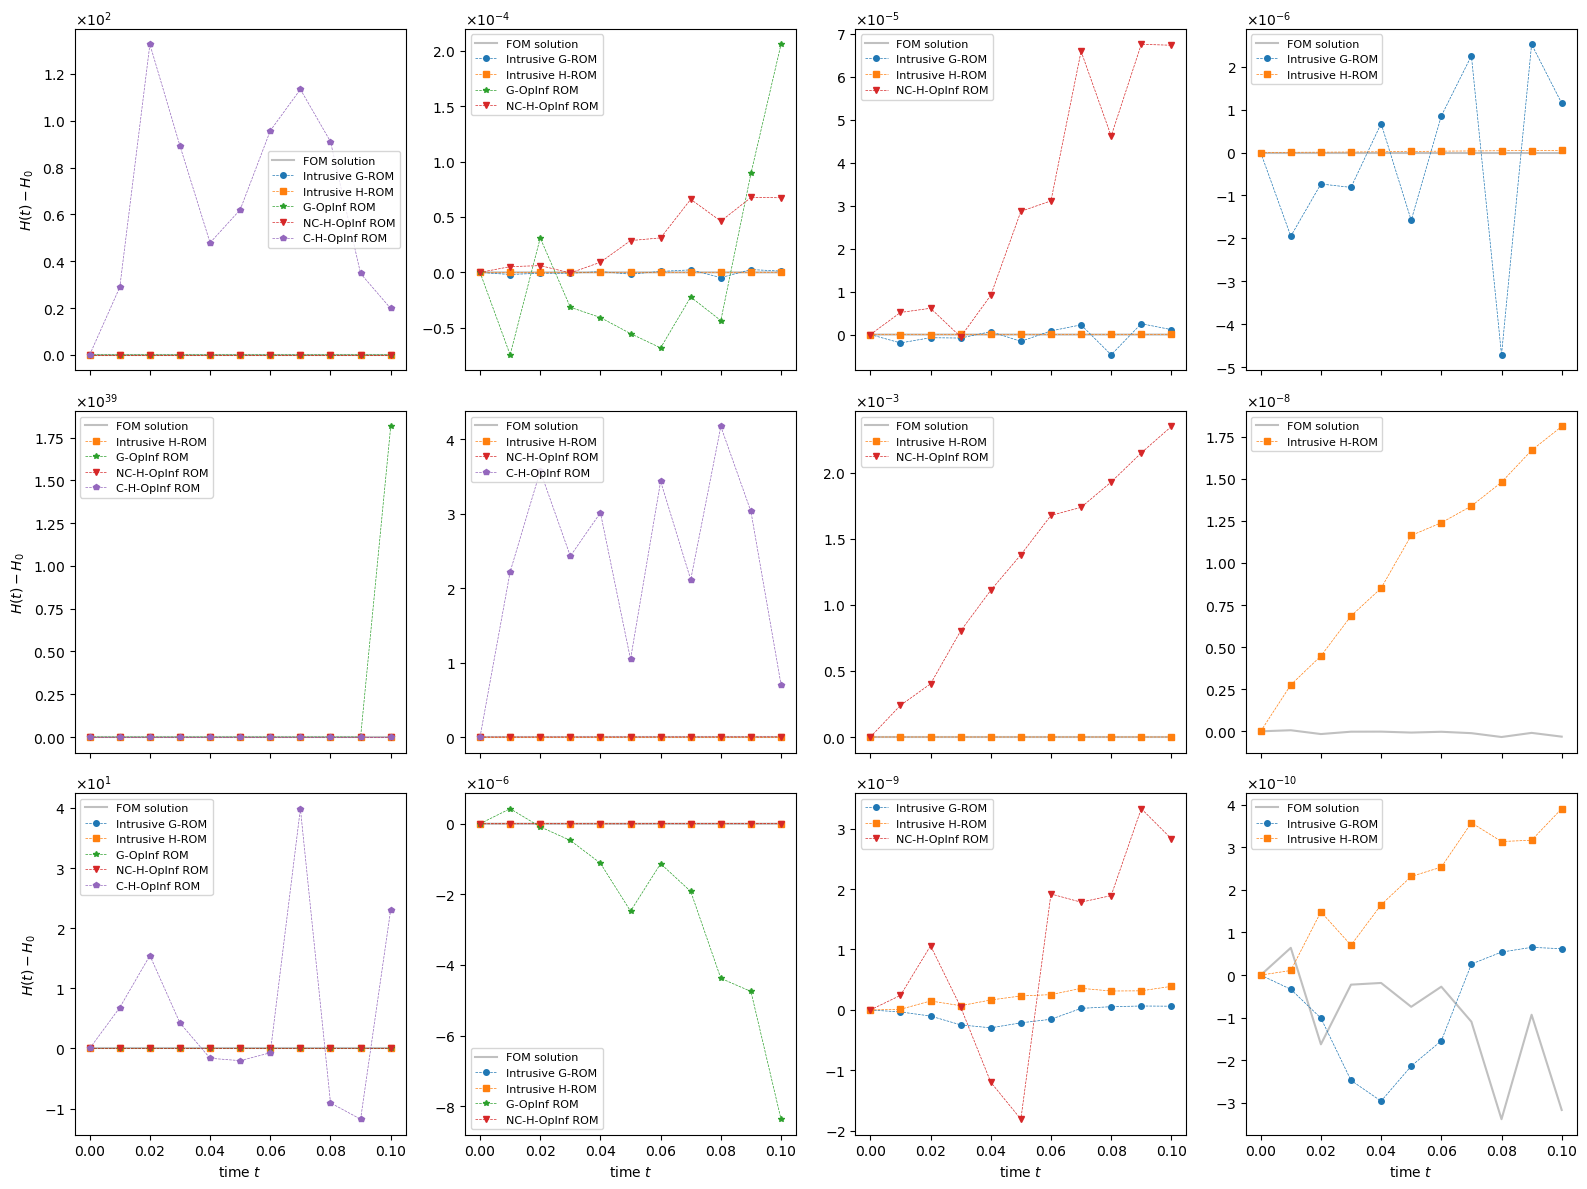

In [8]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(3, 4, figsize=(16,12), sharex=True)

skip=20
i,j = 0,11

titleList   = ['All', 
               'G-OpInf ROM',
               'C-H-OpInf ROM' , 
               'Other H-ROMs']

ax.flatten()[0].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[::skip]-exactE[::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)


i,j = 1,-1

ax.flatten()[4].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[4].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[5].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[6].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[6].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[6].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[6].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[7].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[7].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[7].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)

i,j = 2,-2

ax.flatten()[8].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[8].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[9].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[1].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[10].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[10].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[10].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[11].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[11].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[11].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)

for i in range(3):
    ax[i,0].set_ylabel(r'$H(t) - H_0$')

for i in range(4):
    ax[-1,i].set_xlabel('time $t$')

for i in range(12):
    # ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
# plt.savefig(f'EnergyLinearElastic', transparent=True)
plt.show()


### Experiment testing effect of regularization

0 the relative L2 errors for generic OpInf are [2.96e-08 2.96e-08 2.96e-08 2.96e-08 3.03e-08 6.28e-08 5.46e-07 5.44e-06
 5.44e-05 5.44e-04 5.44e-03 5.44e-02 4.97e-01 9.95e-01]
0 the relative L2 errors for noncanonical Hamiltonian OpInf are [5.70e-01 5.50e-01 5.39e-01 3.14e-01 6.24e-01 4.42e-01 5.31e-01 7.05e-01
 3.58e-01 3.17e-01 2.95e-01 3.63e-01 4.36e-01 9.80e-01]
0 the relative L2 errors for canonical Hamiltonian OpInf are [1.46e+00 1.46e+00 1.46e+00 1.46e+00 1.46e+00 1.46e+00 1.46e+00 1.46e+00
 1.46e+00 1.46e+00 1.46e+00 1.46e+00 1.46e+00 1.48e+00]
0 the relative L2 errors for boris/zhu Hamiltonian OpInf are [9.53e+28 9.53e+28 9.53e+28 9.53e+28 9.53e+28 9.53e+28 9.53e+28 9.53e+28
 9.53e+28 9.52e+28 9.49e+28 9.20e+28 6.74e+28 3.51e+27]

1 the relative L2 errors for generic OpInf are [5.31e+139 4.23e+134 1.84e+25 4.61e+82 1.67e+39 inf 1.25e+42 5.15e+116
 5.77e+22 4.16e+13 1.81e+44 2.56e+86 8.72e+02 inf]
1 the relative L2 errors for noncanonical Hamiltonian OpInf are [6.91e-01 6.89e-0

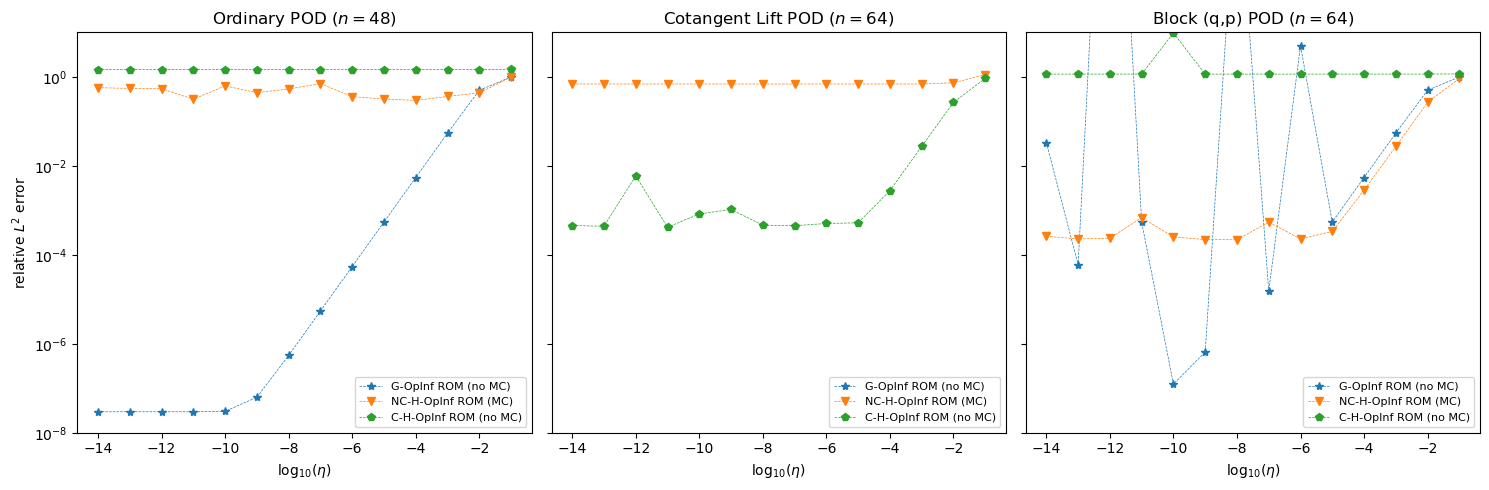

In [9]:
### Exact solution
Ttest     = 1e-1
NtTest    = 201
tTest     = np.linspace(0, Ttest, NtTest)
ic        = data[0][:,0]
# Xac       = X
# Xac = ru.integrate_Linear_HFOM(tTest, ic, Jsp, Asp)[0]
# exactE = Hamil(Xac, Asp)

Xd, gH, L, A = xDotData, gradHData, Jsp, Asp

### Parameters
oneShot = False
UmatList    = [UU, [UU2,UU2], [UUq,UUp]]
# UmatList    = [UU]
MCtog       = True
if MCtog:
    UmatListMC = [UUmc, [UU2mc, UU2mc], [UUqmc, UUpmc]]
    # UmatListMC = [[UUqmc, UUpmc]]
    # UmatListMC = [UUmc]


nList = [4*(11+1), 4*(15+1), 4*(15+1)]
regList=[10**i for i in range(14)]

eOpH   = np.zeros((3, 14))
eOp    = np.zeros((3, 14))
eOpA   = np.zeros((3, 14))
eOpAbz   = np.zeros((3, 14))

# HamileIntG = np.zeros((3, len(nList), NtTest))
# HamileIntH = np.zeros((3, len(nList), NtTest))
# HamileOpH  = np.zeros((3, len(nList), NtTest))
# HamileOp   = np.zeros((3, len(nList), NtTest))
# HamileOpA  = np.zeros((3, len(nList), NtTest))

# XrecIntG = np.zeros((3, len(nList), 2*Nover2, NtTest))
# XrecIntH = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((14, 2*Nover2, NtTest))
XrecOpH  = np.zeros((14, 2*Nover2, NtTest))
XrecOpA  = np.zeros((14, 2*Nover2, NtTest))
XrecOpAbz  = np.zeros((14, 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

titleList   = ['Ordinary POD ($n=48$)', 
               'Cotangent Lift POD ($n=64$)',
               'Block (q,p) POD ($n=64$)']

alpha=1

for l,n in enumerate(nList):

    OpInfLists  = ou.build_OpInf_stuff(UmatList[l], X[:,:Nt], Xd[:,:Nt], 
                                        gH[:,:Nt], L, n)
    OpLists     = ru.build_Linear_ROM_Ops(UmatList[l], L, A, ic, MC=False)
    OpListOL    = list(OpLists[0])

    if MCtog:
        OpInfListMC = ou.build_OpInf_stuff(UmatListMC[l], X[:,:Nt], Xd[:,:Nt], 
                                            gH[:,:Nt], L, n, MC=True)
        OpListsMC   = ru.build_Linear_ROM_Ops(UmatListMC[l], L, A, ic, MC=True)
        OpListMCOL  = list(OpListsMC[0])

    for i, reg in enumerate(regList):

        DhatOpFull            = ou.G_OpInf(OpInfLists[-1], n, None, eps=1.0e-14*reg)

        if not oneShot:
            # Compute for each n
            DhatOp  = ou.G_OpInf(OpInfLists[-1], n, None, eps=1.0e-14*reg)
            if MCtog:
                LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=1.0e-14*reg)
            else:
                LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=1.0e-14*reg)
            
            AhatOp        = ou.C_H_OpInf(OpInfLists[1], n, None, eps=1.0e-14*reg, BorisZhu=False)
            AhatOpbz      = ou.C_H_OpInf(OpInfLists[1], n, None, eps=1.0e-14*reg, BorisZhu=True)
        
        if MCtog:
            OpListMCOL[0] = LhatHOpMC
            try:
                XrecOpH[i]  = ru.integrate_Linear_ROM(tTest, OpListMCOL, ic, UmatListMC[l],
                                                    n, MC=True, Hamiltonian=True)
            except ValueError:
                pass
        else:
            OpListOL[0] = LhatHOp
            try:
                XrecOpH[i]  = ru.integrate_Linear_ROM(tTest, OpListOL, ic, UmatList[l],
                                                    n, MC=False, Hamiltonian=True)
            except ValueError:
                pass

        try:
            XrecOp[i]   = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UmatList[l])
            XrecOpA[i]  = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, UmatList[l], L)
            XrecOpAbz[i]  = ru.integrate_OpInf_ROM(tTest, AhatOpbz, ic, UmatList[l], L)
        except ValueError:
            pass

        eOp[l,i]   = ru.relError(Xac, XrecOp[i])
        eOpH[l,i]  = ru.relError(Xac, XrecOpH[i])
        eOpA[l,i]  = ru.relError(Xac, XrecOpA[i])
        eOpAbz[l,i]  = ru.relError(Xac, XrecOpAbz[i])
    
    # Print error magnitudes
    print(f'{l} the relative L2 errors for generic OpInf are {eOp[l]}')
    print(f'{l} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[l]}')
    print(f'{l} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[l]}')
    print(f'{l} the relative L2 errors for boris/zhu Hamiltonian OpInf are {eOpAbz[l]}' + '\n')

    
    listo = [-(14-j) for j in range(14)]
    ax.flatten()[l].semilogy(listo, eOp[l],  label='G-OpInf ROM (no MC)', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[l].semilogy(listo, eOpH[l], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[l].semilogy(listo, eOpA[l], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    # if l==1:
    #     ax.flatten()[1].semilogy(listo, eOpAbz[l], label='H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[l].set_xlabel(r'$\log_{10}(\eta)$')
    ax.flatten()[l].set_title(f'{titleList[l]}')
    ax.flatten()[l].legend(prop={'size':8}, loc=4)
    ax.flatten()[l].set_ylim([10**-8, 10.])

ax.flatten()[0].set_ylabel(r'relative $L^2$ error')

plt.tight_layout()
# plt.savefig(f'PlatePlotReg', transparent=True)
plt.show()

# 16 - pqblock
# 24 - cotlift
# 12 - ord


In [10]:
exo_copy.close()

Closing exodus file: beam_vecIC_100_written.e
